# 1 Importation

## 1.1 Les Bibliothèques

In [1]:
# Import des bibliothèques nécessaires
import pandas as pd
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import statsmodels.api as sm
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## 1.2 Le dataset

In [2]:
# Charger le fichier CSV
billets_df = pd.read_csv('billets.csv', delimiter=';')

# 2 Etudes des données

## 2.1 Recherche des valeurs manquantes

In [3]:
# Vérification des colonnes avec des données manquantes dans le DataFrame billets_df
missing_data = billets_df.isnull().sum()

# Afficher les colonnes avec des données manquantes et leur nombre
for column, missing_count in missing_data.items():
    if missing_count > 0:
        print(f"Colonne '{column}' a {missing_count} données manquantes.")


Colonne 'margin_low' a 37 données manquantes.


## 2.2 Aperçu des données

In [4]:
# Aperçu des données
print("Aperçu des données :")
print(billets_df.head())

Aperçu des données :
   is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54  


In [5]:
# Description statistique des données
print("\nDescription statistique des données :")
print(billets_df.describe().round(2))


Description statistique des données :
       diagonal  height_left  height_right  margin_low  margin_up   length
count   1500.00      1500.00       1500.00     1463.00    1500.00  1500.00
mean     171.96       104.03        103.92        4.49       3.15   112.68
std        0.31         0.30          0.33        0.66       0.23     0.87
min      171.04       103.14        102.82        2.98       2.27   109.49
25%      171.75       103.82        103.71        4.01       2.99   112.03
50%      171.96       104.04        103.92        4.31       3.14   112.96
75%      172.17       104.23        104.15        4.87       3.31   113.34
max      173.01       104.88        104.95        6.90       3.91   114.44


In [6]:
# Répartition des vrais et faux billets
print("\nRépartition des vrais et faux billets :")
print(billets_df['is_genuine'].value_counts())


Répartition des vrais et faux billets :
True     1000
False     500
Name: is_genuine, dtype: int64


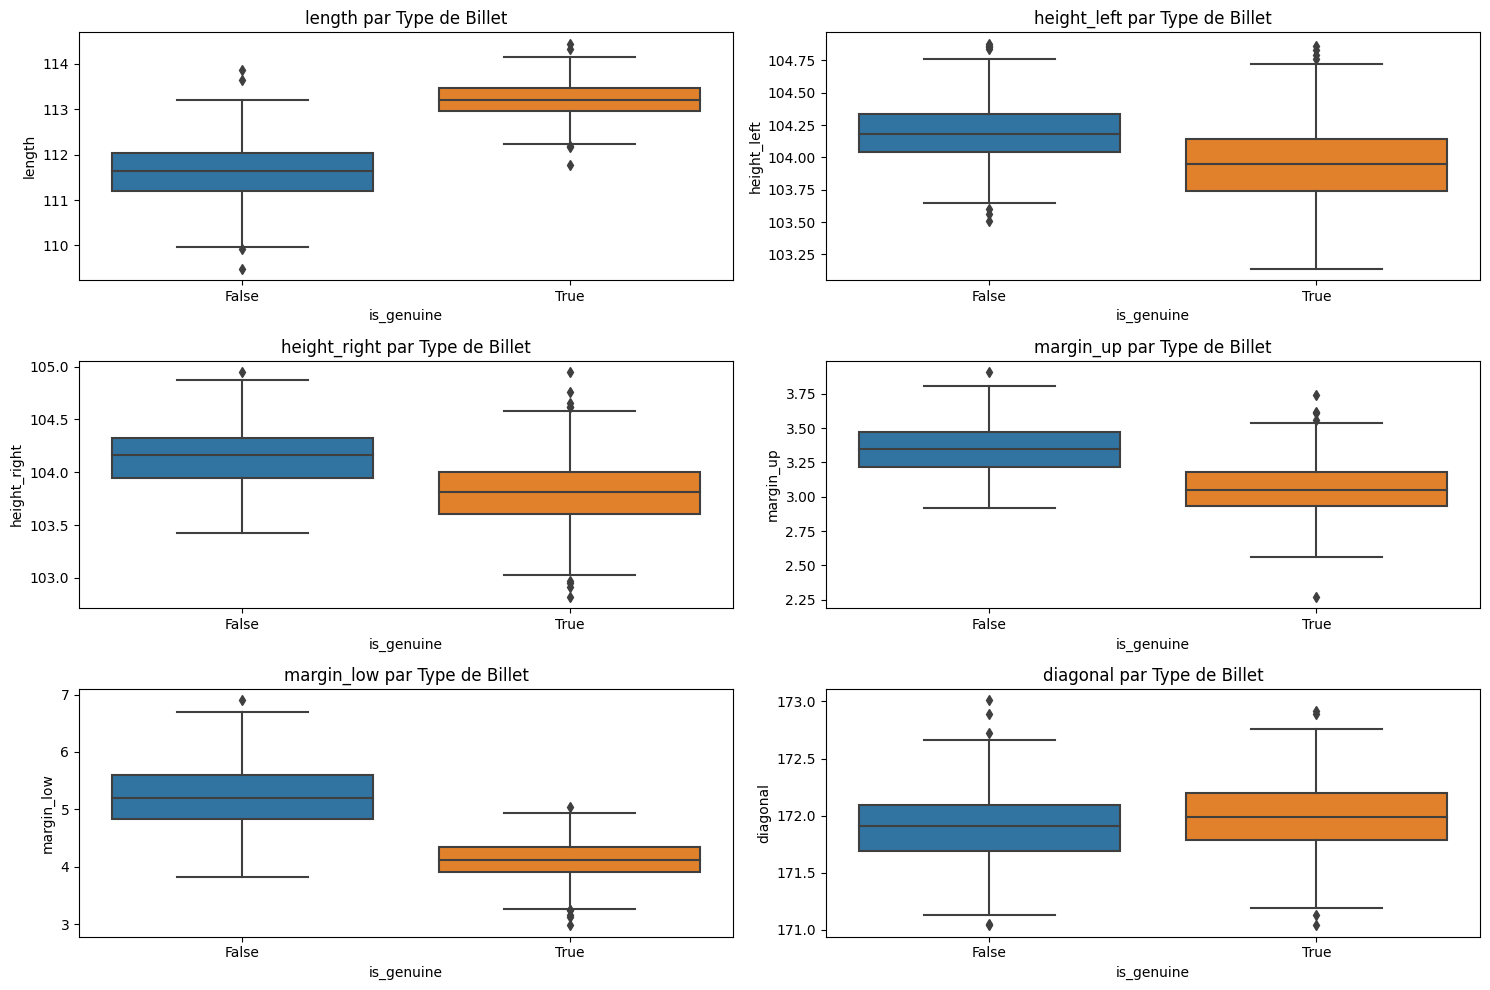

In [7]:
# Boîtes à moustaches pour visualiser les différences entre les vrais et les faux billets
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['length', 'height_left', 'height_right', 'margin_up', 'margin_low', 'diagonal']):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x='is_genuine', y=feature, data=billets_df)
    plt.title(f'{feature} par Type de Billet')
plt.tight_layout()
plt.show()

# 3 Création d'un modele de regression

## 3.1  Créer un modèle de régression avec toutes les variables disponibles.

In [8]:
#Cette ligne crée un modèle pour prédire la valeur de la variable margin_low à partir d'autres caractéristiques des billets, en utilisant les données fournies et calcule les meilleurs paramètres pour ce modèle.
reg_multi = smf.ols('margin_low ~ is_genuine + diagonal + height_left + height_right + margin_up + length', data=billets_df).fit()


## 3.2 Analyse et test des résidus

### 3.2.1 Test de  Breush Pagan

In [9]:
#Ce code réalise un test statistique pour vérifier si les erreurs de notre modèle de régression varient de manière significative avec les niveaux de nos variables prédictives. Si c'est le cas, cela peut signifier que notre modèle n'est pas aussi fiable pour certaines données que pour d'autres, un phénomène connu sous le nom d'hétéroscédasticité. Il affiche ensuite les résultats du test, y compris une valeur-p qui, si elle est faible, indique une hétéroscédasticité significative. 


# Récupération des résidus et des valeurs prédites du modèle
residuals = reg_multi.resid
predictions = reg_multi.fittedvalues


# Test de Breusch-Pagan
bp_test = sms.het_breuschpagan(residuals, reg_multi.model.exog)


# Affichage des résultats
print('Lagrange multiplier statistic:', bp_test[0])
print('p-value:', bp_test[1])
print('f-value:', bp_test[2])
print('f p-value:', bp_test[3])

Lagrange multiplier statistic: 165.81873103787635
p-value: 3.4639579716027045e-33
f-value: 31.020089246318673
f p-value: 3.233973422097264e-35


### 3.2.2 Test de white

In [10]:

# Calcul des valeurs prédites et des résidus
predictions = reg_multi.fittedvalues
residuals = reg_multi.resid

# Préparation des termes pour le test de White
X = reg_multi.model.exog
residuals_squared = residuals**2

# Exécution du test de White
white_test = sm.stats.diagnostic.het_white(residuals_squared, X)

# Affichage des résultats
print('Test statistic:', white_test[0])
print('p-value:', white_test[1])
print('f-value:', white_test[2])
print('f p-value:', white_test[3])

Test statistic: 103.57143422503363
p-value: 3.245842909024683e-11
f-value: 4.20789302696582
f p-value: 1.1197935392072763e-11


### 3.2.3 QQ-plot : Diagnostic de normalité des résidus 

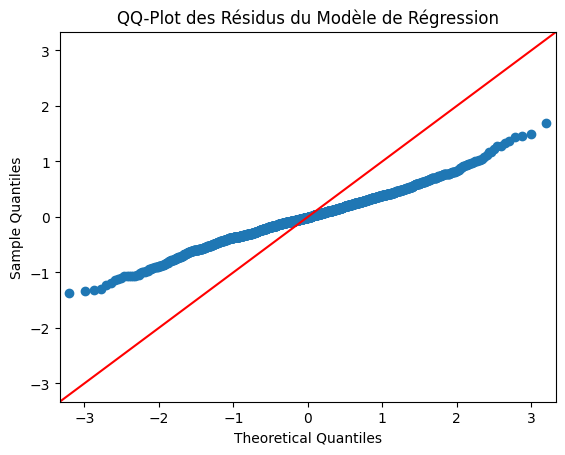

In [11]:
# Création du QQ-Plot
sm.qqplot(residuals, line='45')
plt.title("QQ-Plot des Résidus du Modèle de Régression")
plt.show()

## 3.3.1 : Élimination régressive des variables

In [12]:
# Dans cette étape, nous allons éliminer progressivement les variables qui ne sont pas statistiquement significatives. La p-valeur est utilisée comme critère : une variable est considérée comme non significative si sa p-valeur est supérieure à 0,05.
variables = ['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_up', 'length']

while True:
    # Construction de la formule de régression
    formula = 'margin_low ~ ' + ' + '.join(variables)
    
    # Entraînement du modèle de régression
    reg_multi = smf.ols(formula, data=billets_df).fit()
    
    # Récupération des p-valeurs
    pvalues = reg_multi.pvalues.drop('Intercept')
    
    # Si toutes les p-valeurs sont inférieures à 0.05, on sort de la boucle
    if pvalues.max() < 0.05:
        break
    
    # Sinon, on élimine la variable avec la p-valeur la plus élevée
    remove = pvalues.idxmax()
    variables.remove(remove)

# Cette boucle crée un modèle de régression linéaire pour prédire margin_low et retire progressivement les variables les moins significatives (celles dont la p-valeur est supérieure à 0,05) jusqu'à ce que toutes les variables restantes aient une influence statistiquement significative sur margin_low.

### 3.3.2 Utilisation du modèle


In [13]:
# Création d'un dataframe avec les variables du modèle final
model_var = billets_df[variables].copy()

# Prédiction de margin_low
margin_low_prev = reg_multi.predict(model_var)

# Remplacement des valeurs manquantes dans le DataFrame d'origine
billets_df['margin_low'].fillna(margin_low_prev, inplace=True)


### 3.3.3 Vérification des valeurs manquantes

In [14]:
# Vérifier la présence de valeurs manquantes dans le DataFrame
missing_values_check = billets_df.isnull().sum()

missing_values_check

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

# 4 Analyse Comparative des Caractéristiques des Billets Vrais et Faux

## 4.1 Representation global des comparatives 

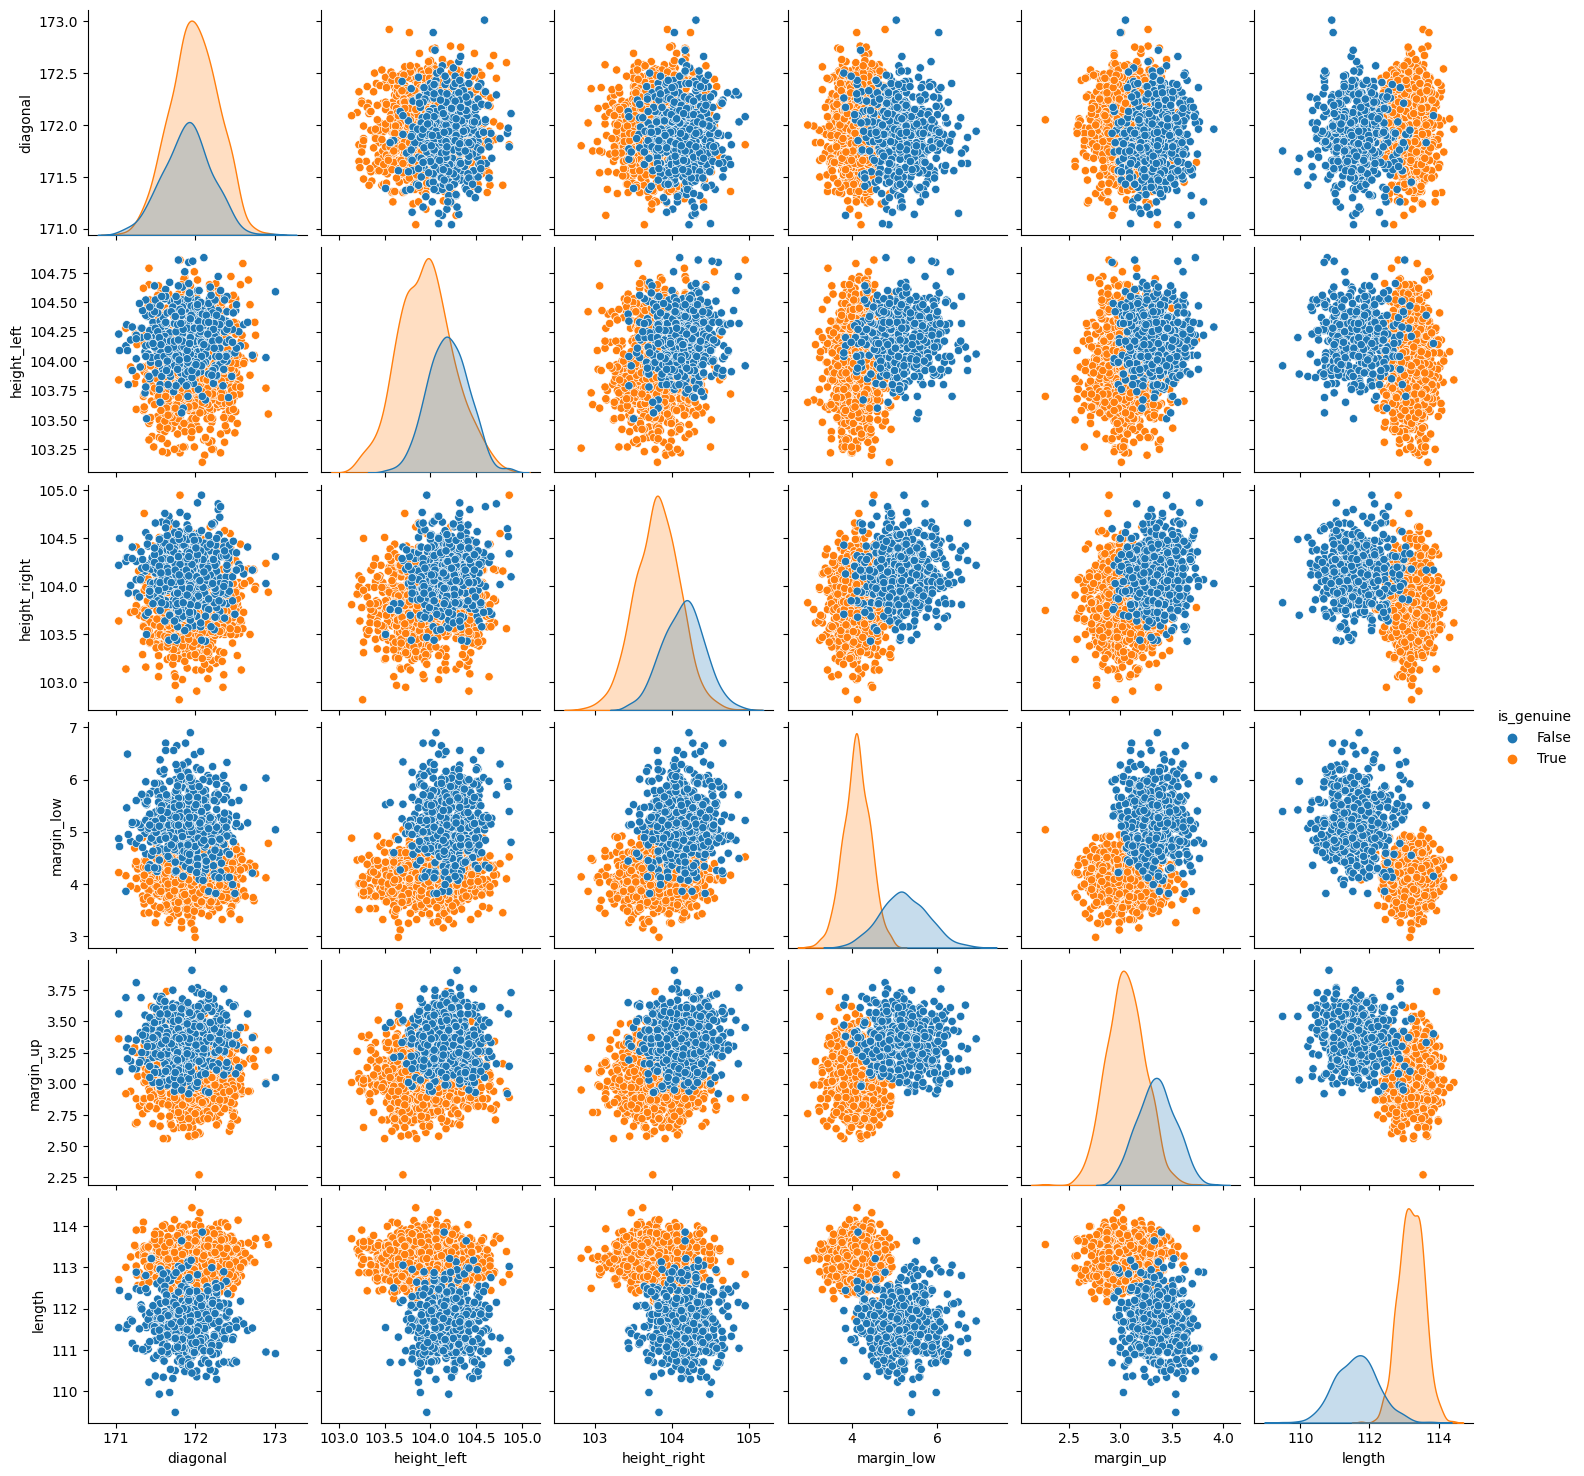

<Figure size 1500x1000 with 0 Axes>

In [15]:
sns.pairplot(billets_df, hue='is_genuine', diag_kind='kde')

# Réglage de la taille de la figure si nécessaire
plt.figure(figsize=(15, 10))

plt.show()

## 4.2 Comparatif des vrais et faux billets sur une caractéristique  

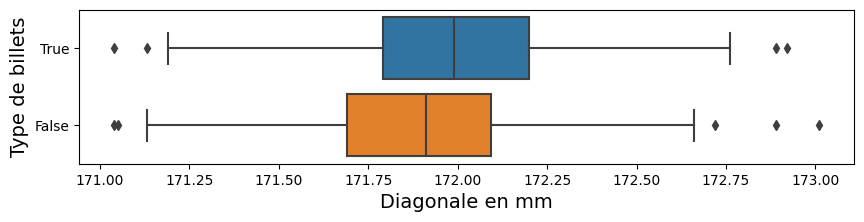

In [16]:
# Convertir les valeurs booléennes en chaînes de caractères pour faciliter l'utilisation avec Seaborn
str_genui_data = billets_df.copy()
str_genui_data['is_genuine'] = str_genui_data['is_genuine'].map({True: 'True', False: 'False'})

# 4.1 Diagonale
plt.figure(figsize=(10, 2))
sns.boxplot(x="diagonal", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Diagonale en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()



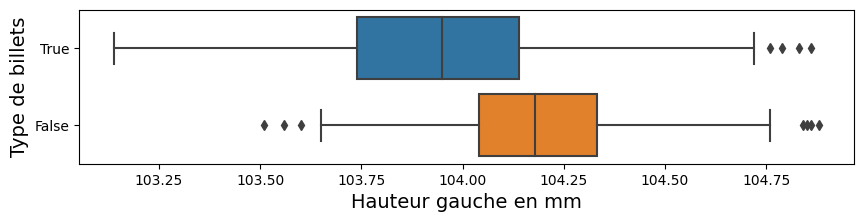

In [17]:
# 4.3 Hauteur gauche
plt.figure(figsize=(10, 2))
sns.boxplot(x="height_left", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Hauteur gauche en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()



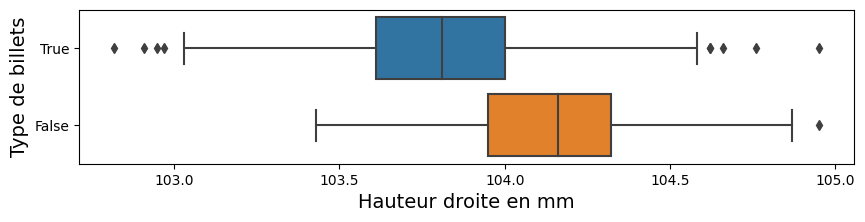

In [18]:
# 4.4 Hauteur droite
plt.figure(figsize=(10, 2))
sns.boxplot(x="height_right", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Hauteur droite en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()



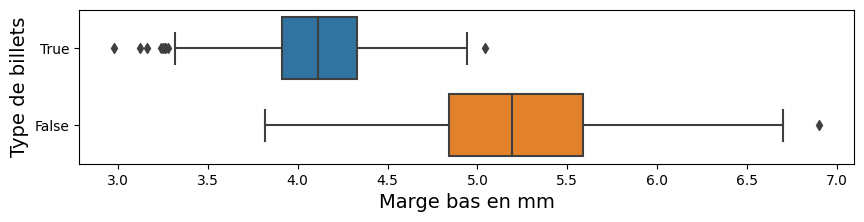

In [19]:
# 4.5 Marge du bas
plt.figure(figsize=(10, 2))
sns.boxplot(x="margin_low", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Marge bas en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()



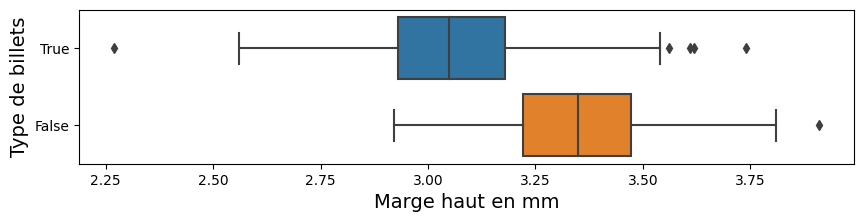

In [20]:
# 4.6 Marge haut
plt.figure(figsize=(10, 2))
sns.boxplot(x="margin_up", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Marge haut en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()



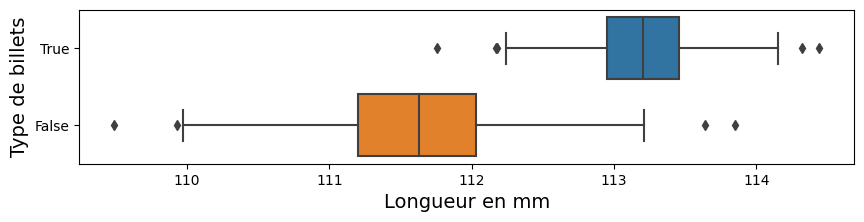

In [21]:
# 4.7 Longueur
plt.figure(figsize=(10, 2))
sns.boxplot(x="length", 
            y="is_genuine",
            data=str_genui_data)
plt.xlabel('Longueur en mm', fontsize=14)
plt.ylabel('Type de billets', fontsize=14)
plt.show()

# 5 Algorithmes de détection


### 5.1 Préparation des données

Nous allons d'abord convertir les valeurs de 'is_genuine' en nombres entiers pour faciliter l'entraînement.


In [22]:
int_genui_data = billets_df.copy()
int_genui_data['is_genuine'] = int_genui_data['is_genuine'].map({True: 0, False: 1})

# Séparation des variables indépendantes (X) et de la variable cible (y)
X = int_genui_data.drop(columns="is_genuine")
y = int_genui_data.is_genuine


### 5.2 Partage de l'échantillon pour le test et l'entraînement

Nous allons diviser le jeu de données en deux : un ensemble d'entraînement et un ensemble de test.


In [23]:
# Cette ligne divise l'ensemble de données en deux parties : une pour l'entraînement du modèle (80 % des données) et l'autre pour le test (20 % des données), en utilisant un état aléatoire pour la reproductibilité, puis elle affiche la taille de chaque sous-ensemble pour vérification.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape}")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape}")

Nous avons X_train de forme (1200, 6) et y_train de forme (1200,)
Nous avons X_test de forme (300, 6) et y_test de forme (300,)


### 5.3 Classification des billets

#### 5.3.a Régression logistique

In [24]:
estimator = LogisticRegression(solver='liblinear')
estimator.fit(X_train, y_train)


LogisticRegression(solver='liblinear')

Prédictions et probabilités


In [25]:
# Après avoir entraîné le modèle, nous pouvons l'utiliser pour faire des prédictions sur l'ensemble de test. Nous pouvons également obtenir les probabilités d'appartenance à chaque classe pour chaque observation.

y_pred = estimator.predict(X_test)
y_prob = estimator.predict_proba(X_test).round(2)



Test du modèle avec une matrice de confusion

Nous allons tester la qualité de notre modèle de régression logistique en utilisant une matrice de confusion.


In [26]:
def confusion(y_test, y_pred):
    """Affiche une matrice de confusion formatée"""
    mat = confusion_matrix(y_test, y_pred)
    mat_df = pd.DataFrame(mat)
    mat_df.columns = [f"pred_{i}" for i in mat_df.columns]
    mat_df.index = [f"test_{i}" for i in mat_df.index]
    return mat_df

confusion_mat = confusion(y_test, y_pred)
confusion_mat


,pred_0,pred_1
test_0,190,0
test_1,3,107


Évaluation du modèle

Enfin, évaluons la performance de notre modèle en calculant sa précision sur les ensembles d'entraînement et de test.


In [27]:
def score(estimator):
    tr_score = estimator.score(X_train, y_train).round(2)
    te_score = estimator.score(X_test, y_test).round(2)
    return tr_score, te_score

tr_score, te_score = score(estimator)
print(f"score train : {tr_score} score test : {te_score}")


score train : 0.99 score test : 0.99


In [28]:
# Assurez-vous que votre modèle de régression logistique est nommé 'estimator'
# Si ce n'est pas le cas, remplacez 'estimator' par le nom de votre modèle
y_pred = estimator.predict(X_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.99
Precision: 1.0
Recall: 0.9727272727272728
F1 Score: 0.9861751152073733


#### 5.3.b Courbe de ROC

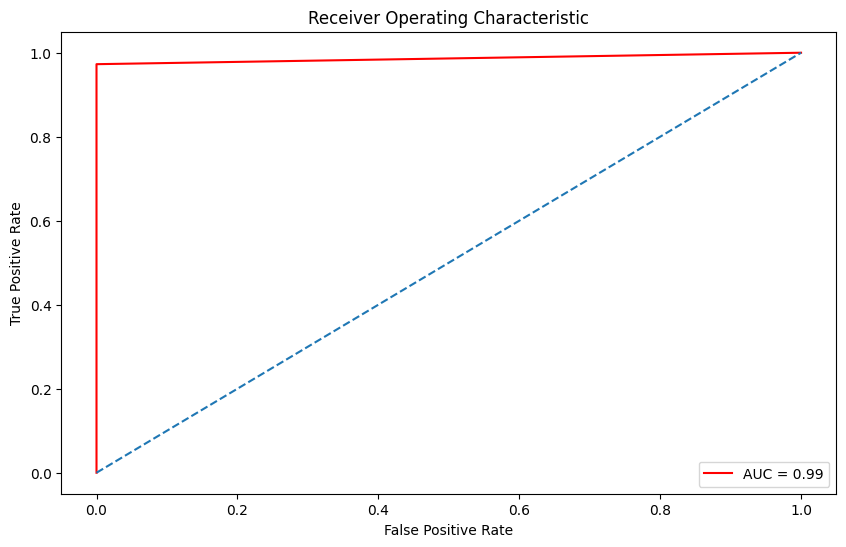

In [29]:
#La courbe ROC (Receiver Operating Characteristic) est un outil graphique utilisé en classification pour étudier les performances d'un modèle.

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate).round(2)

plt.figure(figsize=(10, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, color='red', label=f'AUC = {roc_auc}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### 5.3.c K-means

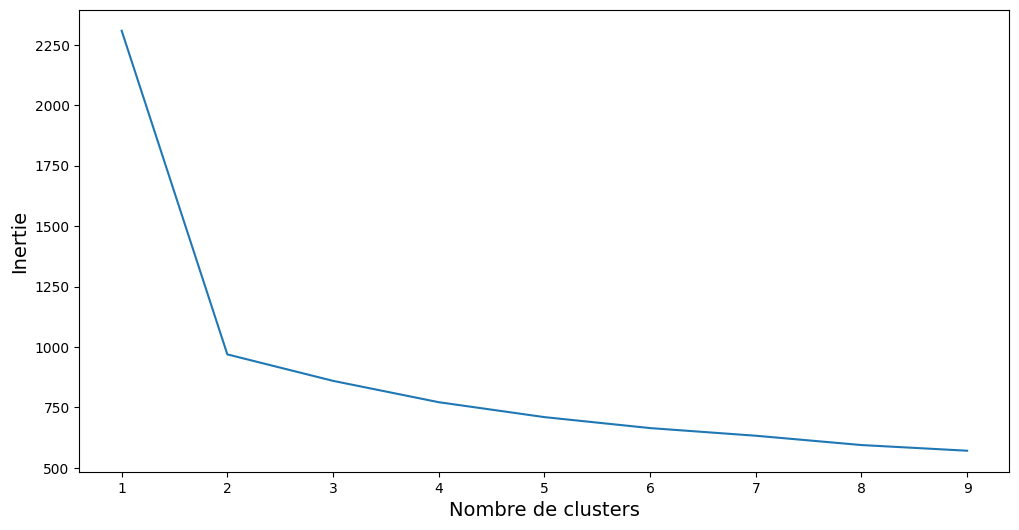

In [30]:
# Utilisation de la méthode du coude pour déterminer le nombre optimal de clusters
inertia = []
k_list = range(1, 10)

for i in k_list:
    kmeans = KMeans(n_clusters=i, n_init=10)

    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Affichage de l'inertie intraclasse en fonction du nombre de clusters
plt.figure(figsize=(12, 6))
plt.ylabel("Inertie", fontsize=14)
plt.xlabel("Nombre de clusters", fontsize=14)
plt.plot(k_list, inertia)
plt.show()


### Entraînement et test du modèle K-means


In [31]:
kmeans = KMeans(n_clusters=2,n_init=10)
kmeans.fit(X_train, y_train)
prediction = kmeans.predict(X_test)

# Calcul de la précision
correct = sum([1 for i in range(len(y_test)) if prediction[i] == y_test.iloc[i]])
accuracy_kmeans = correct / len(y_test)

# Affichage de la matrice de confusion pour K-means
kmeans_mat = confusion(y_test, prediction)
kmeans_mat


,pred_0,pred_1
test_0,0,190
test_1,104,6


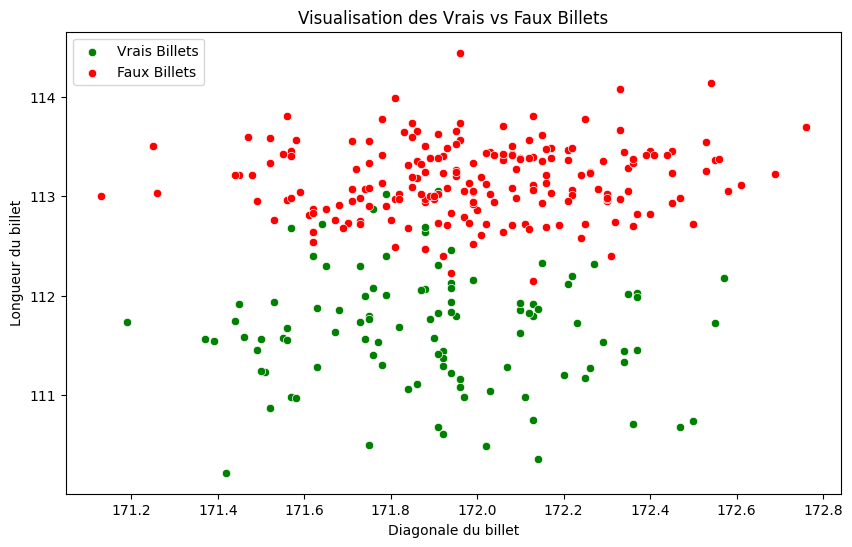

In [40]:
# Utiliser 'diagonal' et 'length' pour le tracé
feature_1 = X_test['diagonal']
feature_2 = X_test['length']

# Tracer le graphique
plt.figure(figsize=(10, 6))
# Les vrais billets (prédits) en vert
sns.scatterplot(x=feature_1[prediction == 0], y=feature_2[prediction == 0], color='green', label='Vrais Billets')
# Les faux billets (prédits) en rouge
sns.scatterplot(x=feature_1[prediction == 1], y=feature_2[prediction == 1], color='red', label='Faux Billets')
plt.title('Visualisation des Vrais vs Faux Billets')
plt.xlabel('Diagonale du billet')
plt.ylabel('Longueur du billet')
plt.legend()
plt.show()


In [32]:
accuracy_kmeans

0.02

In [33]:
from sklearn.metrics import silhouette_score

# Calcul du score de silhouette pour les prédictions de K-means
silhouette_avg = silhouette_score(X_test, prediction)
print("Le score de silhouette moyen est :", silhouette_avg)


Le score de silhouette moyen est : 0.500576484835433


# 6 Application du modèle sur les données de production

Nous allons appliquer le modèle de régression logistique que nous avons formé précédemment sur un nouvel ensemble de données pour déterminer l'authenticité des billets.


## 6.1 Chargement des données

In [34]:
# Chargement des données
prod_data = pd.read_csv('billets_production.csv')
print(prod_data.shape)
prod_data.head()


(5, 7)


,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


## 6.2 Préparation des données

Nous allons supprimer la colonne 'id' car elle n'est pas nécessaire pour la prédiction.


In [35]:
prod_data = prod_data.drop(columns='id')
prod_data


,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.76,104.01,103.54,5.21,3.30,111.42
1,171.87,104.17,104.13,6.00,3.31,112.09
2,172.00,104.58,104.29,4.99,3.39,111.57
3,172.49,104.55,104.34,4.44,3.03,113.20
4,171.65,103.63,103.56,3.77,3.16,113.33


## 6.3 Application du modèle de régression logistique

Nous allons utiliser notre modèle précédemment formé pour prédire si ces billets sont authentiques ou non.


In [36]:
prod_genui = estimator.predict(prod_data)
prod_genui


array([1, 1, 1, 0, 0], dtype=int64)

## 6.4 Ajout des prédictions au dataframe original

Nous allons ajouter une colonne 'is_genuine' au dataframe pour indiquer si le billet est authentique selon notre modèle.


In [37]:
prod_data["is_genuine"] = prod_genui

# Convertir les prédictions en valeurs booléennes
prod_data.is_genuine = ~prod_data.is_genuine.astype('bool')

prod_data


,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,False
1,171.87,104.17,104.13,6.00,3.31,112.09,False
2,172.00,104.58,104.29,4.99,3.39,111.57,False
3,172.49,104.55,104.34,4.44,3.03,113.20,True
4,171.65,103.63,103.56,3.77,3.16,113.33,True
